In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('./Project_5_data/train.csv')

# 4. Работаем с датасетом

### Задание 1
Сколько записей содержит набор данных для моделирования?

In [3]:
data.shape

(73799, 14)

Посмотрим на данные:  

|||
|-|-|
|client_id|идентификатор клиента|
|education|уровень образования|
|sex|пол заёмщика|
|age|возраст заёмщика|
|car|флаг наличия автомобиля|
|car_type|флаг автомобиля-иномарки|
|decline_app_cnt|количество отказанных прошлых заявок|
|good_work|флаг наличия «хорошей» работы|
|bki_request_cnt|количество запросов в БКИ|
|home_address|категоризатор домашнего адреса|
|work_address|категоризатор рабочего адреса|
|income|доход заёмщика|
|foreign_passport|наличие загранпаспорта|
|default|наличие дефолта|

### Задание 2
Постройте диаграмму для переменной `default`. Каких клиентов у банка больше?

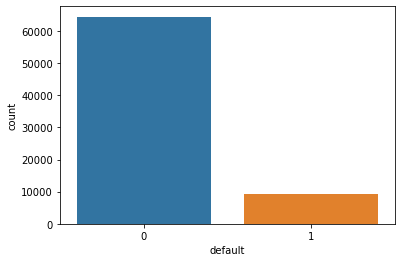

In [4]:
sns.countplot(x="default", data=data);

Посмотрим на тип данных и наличие пропусков:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [6]:
data.isna().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима **предварительная очистка данных**.

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

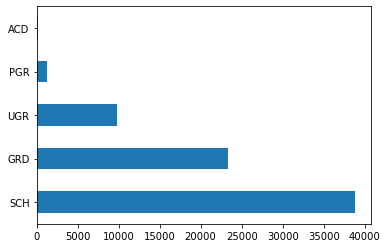

In [7]:
data.education.value_counts().plot.barh();

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.   
Разнесите недостающие признаки в соответствующие категории.

In [8]:
categ_num = data.apply(lambda x: x.nunique())
categ_num

client_id           73799
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
bki_request_cnt        38
home_address            3
work_address            3
income                966
foreign_passport        2
default                 2
dtype: int64

Разделение на категории

In [49]:
bin_feat =  categ_num[categ_num == 2].index.drop(['default'])
categ_feat = categ_num[(categ_num>2) & (categ_num<=20)].index
numeric_feat = categ_num[categ_num>20].index.drop(['client_id'])
bin_feat,categ_feat,numeric_feat

(Index(['sex', 'car', 'car_type', 'good_work', 'foreign_passport'], dtype='object'),
 Index(['education', 'home_address', 'work_address'], dtype='object'),
 Index(['age', 'decline_app_cnt', 'bki_request_cnt', 'income'], dtype='object'))

# 5.Визуализация
Посмотрим на распределение числовых данных:

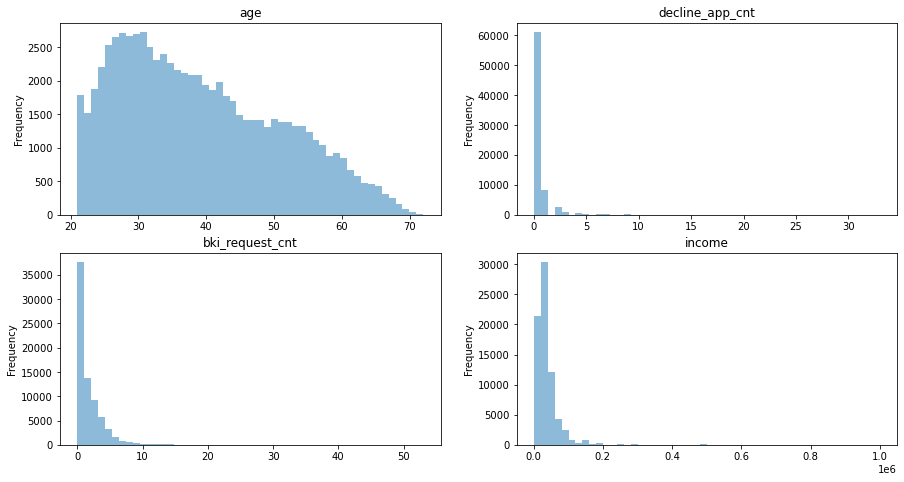

In [50]:
n = len(numeric_feat)
colunms_num = 2
rows_num = n//colunms_num + 1

plt.figure(figsize=(15,4*rows_num))
for i,feat in enumerate(numeric_feat):
        plt.subplot(n//colunms_num + 1, colunms_num, (i+1))
        data[feat].plot.hist(alpha = 0.5,bins=50)
        plt.title(feat)
        

Построим графики распределения логарифмированных переменных.

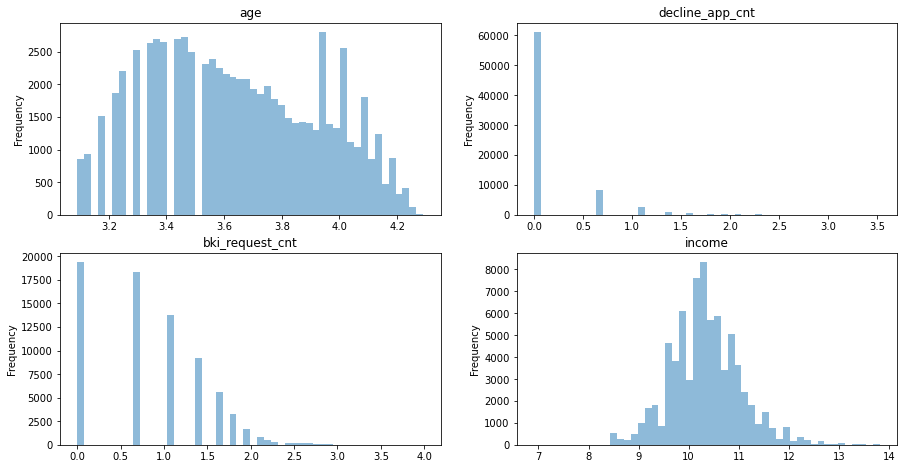

In [51]:
n = len(numeric_feat)
colunms_num = 2
rows_num = n//colunms_num + 1

plt.figure(figsize=(15,4*rows_num))
for i,feat in enumerate(numeric_feat):
        plt.subplot(n//colunms_num + 1, colunms_num, (i+1))
        (np.log(data[feat]+1)).plot.hist(alpha = 0.5,bins=50)
        plt.title(feat)

### Задание 1
Постройте boxplot’ы для численных переменных и ответьте на следующие вопросы:

In [52]:
# sns.boxplot(x='score', y=column, data=dfn,order=column_values)

<AxesSubplot:xlabel='age', ylabel='default'>

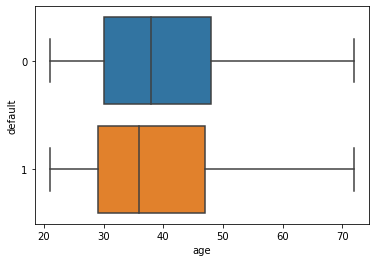

In [53]:
sns.boxplot(x='age', y='default', orient='h',data = data)

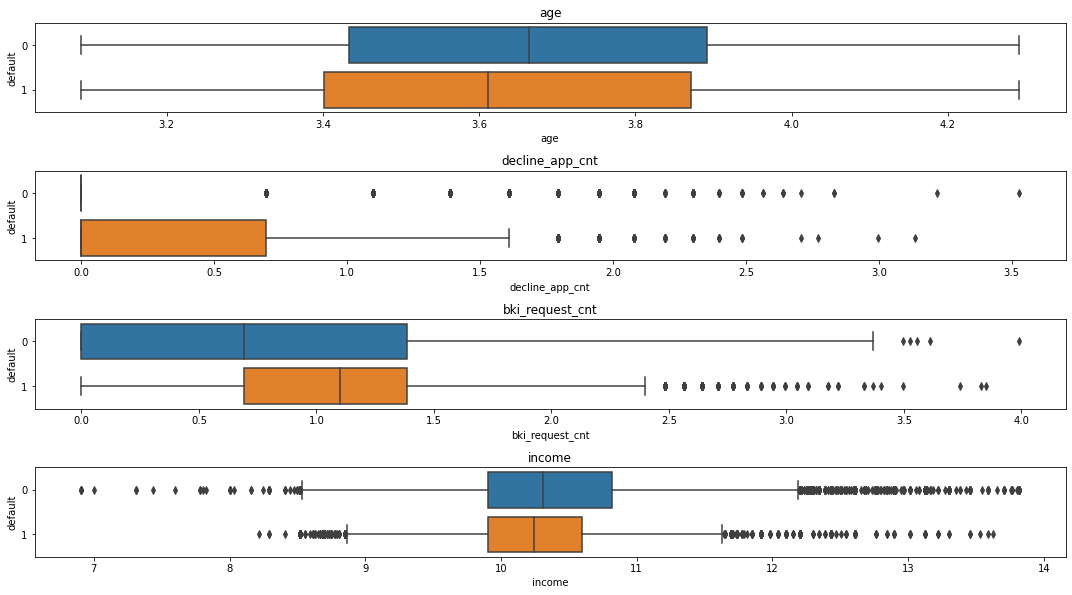

In [54]:
n = len(numeric_feat)
colunms_num = 1
rows_num = n//colunms_num + 1

plt.figure(figsize=(15,2*rows_num))
for i,feat in enumerate(numeric_feat):
        plt.subplot(n//colunms_num + 1, colunms_num, (i+1))
        sns.boxplot(x=np.log(data[feat]+1), y='default', orient='h',data = data)
        plt.title(feat)
plt.tight_layout()

# 6.Оценка корреляций

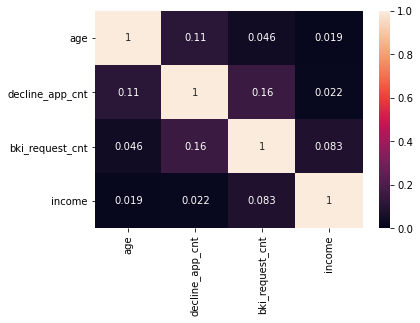

In [55]:
sns.heatmap(data[numeric_feat].corr().abs(), vmin=0, vmax=1, annot=True);

# 7. Значимость непрерывных переменных
Для оценки значимости числовых переменных будем использовать функцию `f_classif` из библиотеки `sklearn`. 

Возможности модуля `sklearn.feature_selection` могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных **t-тестов** для независимых выборок **(2-sample t)**. 

В качестве меры значимости мы будем использовать значение **f-статистики**. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

`
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
`

<AxesSubplot:>

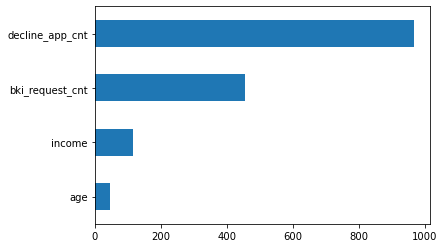

In [56]:
imp_num = pd.Series(f_classif(data[numeric_feat], data['default'])[0], index = numeric_feat)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 8. Категориальные переменные
Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле `sex` значение `sex = female` преобразовать в 0, а `sex = male` — в 1 . Эту простую операцию приходится делать достаточно часто, поэтому в модуле `sklearn.preprocessing` именно для этой задачи реализован класс `LabelEncoder`.

Метод `fit` этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод `transform` непосредственно преобразует значения в числа. После `fit` у l`abel_encoder` будет доступно поле `classes_`, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [57]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 0, 1: 1}


In [58]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_feat:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,3,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,3,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,3,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,3,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,1,1,48,0,0,0,1,1,2,3,30000,1,0


## ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных и бинарных переменных будем использовать функцию `mutual_info_classif` из библиотеки `sklearn`. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

`imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')`   
Упс! Что-то пошло не так...

<AxesSubplot:>

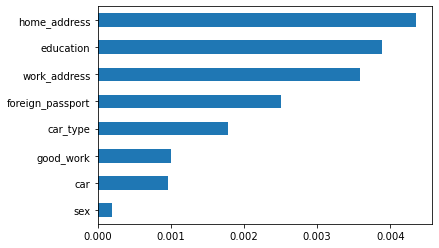

In [60]:
imp_cat = Series(mutual_info_classif(data[bin_feat.append(categ_feat)], data['default'],
                                     discrete_features =True), index = bin_feat.append(categ_feat))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Какой признак самый важный из категориальных?   
Какой признак является наименее важным по мнению `mutual_info_classif`?

In [67]:
imp_cat.index[-1],imp_cat.index[0]

('home_address', 'sex')

# 9. Подготовка данных к машинному обучению

Сначала необходимо провести **разделение на трейн и тест**, а затем применять стандартизирование и все остальное. Перед обучением регрессии нам следует **стандартизировать числовые признаки**, а также **воспользоваться dummy-кодированием для категориальных переменных**, то есть создать отдельную бинарную переменную для каждой категории.

Как вы уже поняли, `LabelEncoder` не совсем подходит для признаков с двумя и большим количеством категорий. Для того, чтобы мы смогли применять линейные модели на таких данных, нам необходим другой метод, который называется `One-Hot Encoding`. Смысл его точно такой же, как у **dummy-кодирования**.

Предположим, что некоторый признак может принимать пять разных значений. В этом случае One Hot Encoding подразумевает создание пяти новых признаков, все из которых равны нулю, за исключением одного. На позицию, соответствующую численному значению признака, мы помещаем 1.

Эта техника реализована в `sklearn.preprocessing` в классе `OneHotEncoder`. По умолчанию `OneHotEncoder` преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей.

In [68]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[categ_feat].values)

# Задание 1
Сколько столбцов вы получили после преобразования данных?

In [69]:
X_cat.shape

(73799, 12)

Стандартизируем числовые переменные:

In [70]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(data[numeric_feat].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [71]:
# Объединяем
X = np.hstack([X_num, data[bin_feat].values, X_cat])
y = data['default'].values

Разделим данные для обучения следующим образом:

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ЗАДАНИЕ

Обучите модель на стандартных настройках [логистической регрессии](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [74]:
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\Manych\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# 10. Оценка качества модели
В качестве методов оценки прогностической способности модели вы решаете использовать **ROC-анализ**.

Вы прекрасно помните из модуля по Классификации, что классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

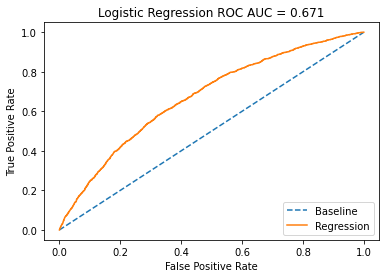

In [75]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## СОВЕТ НЕИЗВЕСТНОГО: РЕГУЛЯРИЗАЦИЯ

In [77]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245
